# From coverage files to differential accessibility

Check what is your working directory.

In [1]:
getwd()

[1] "/home/mag/ATACseq/TestJupyterNotebook/ATAC-seq"

## Load your sample plan

In [2]:
splan <-read.csv("data/metadata.tsv", sep="\t",row.names=1, header=TRUE)
splan

,group,subject
,<chr>,<int>
SRR1822153,Control,1
SRR1822154,Control,2
SRR1822157,Osmotic_stress,1
SRR1822158,Osmotic_stress,2


## Read coverage files

In [3]:
list.files('output/peak_coverage')

[1] "SRR1822153_peaks.bed" "SRR1822154_peaks.bed" "SRR1822157_peaks.bed"
[4] "SRR1822158_peaks.bed"

Get the path to the individual peak files. 

In [4]:
exprs.in <-lapply(rownames(splan), function(x) { paste("output/peak_coverage",'/',x,'_peaks.bed',sep="")}) 

Then read the peak file.  

Column description:
1. chr 
2. start 
3. end 
4. peak_ID 
5. MACS_score  
6. MACS_strand 
7. MACS_fold_enrichment 
8. MACS_-log10(pval) 
9. MACS_-log10(qval) 
10. MACS_summit (0-based offset from chrom start)
11. reads_in_peak 
12. peak_non-zero_bases 
13. peak_length 
14. peak_fraction_covered

In [5]:
counts.exprs <- lapply(exprs.in, read.csv, sep="\t", header=FALSE, check.names=FALSE, col.names=c('chr','start','end', 'peak','score','strand','fold_enr','-log10(pval)','-log10(qval)','summit','reads_in_peak','non-zero_bases','peak_lenght','cov_fraction'))

## Combine the data into a single count table, using peak coordinates as an ID.
edgeR works on a table of integer read counts, with rows corresponding to regions and columns to independent libraries. 

In [6]:
i <- 0
for (sample in counts.exprs) {
    if (i==0) {
        sample$ID <- paste(sample$chr,sample$start,sample$end,sep="_")
        count_table <- data.frame(as.numeric(sample$reads_in_peak), row.names=sample$ID)
        }
    else {count_table <- data.frame(count_table,as.numeric(sample$reads_in_peak))}
    i <- i+1
}
## rename the columns
names(count_table) <- rownames(splan)
head(count_table)

,SRR1822153,SRR1822154,SRR1822157,SRR1822158
,<dbl>,<dbl>,<dbl>,<dbl>
I_38_709,157,149,54,54
I_20734_21103,20,12,22,23
I_29801_29980,21,7,12,22
I_32538_33302,38,34,52,56
I_34434_34710,30,16,10,13
I_45291_45875,38,50,41,56


In [7]:
message("size of the table")
message("number of ATAC peaks")
message(dim(count_table)[1])
message("number of samples")
message(dim(count_table)[2])
message("number of counts per sample")
print(colSums(count_table),na.rm = TRUE)

size of the table

number of ATAC peaks

1419

number of samples

4

number of counts per sample



SRR1822153 SRR1822154 SRR1822157 SRR1822158 
     43926      33489      49600      48409 


## Install / load edgeR

In [8]:
## if necessary, install edgeR 
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("edgeR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'edgeR'”
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    lattice, mgcv, nlme, survival

Old packages: 'digest', 'lifecycle', 'mime', 'pillar', 'tinytex'



In [9]:
# load the edgeR package
library(edgeR)

Le chargement a nécessité le package : limma



## Create a DGE object and normalise the counts

edgeR stores data in a simple list-based data object called a DGEList. The groups are defined in the 2nd columns of our sample plan. 

In [10]:
y <- DGEList(counts=count_table,group=splan$group)

The calcNormFactors() function normalizes for reads composition by finding a set of scaling factors for the library sizes that minimize the log-fold changes between the samples for most regions. The default method for computing these scale factors uses a trimmed mean of M-values (TMM) between each pair of samples. The effective library size replaces the original library size in all downsteam analyses.

In [11]:
y <- calcNormFactors(y)

Check that the design is correct and see the normalisation factors. 

In [12]:
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
SRR1822153,Control,43926,0.9901133
SRR1822154,Control,33489,0.9417088
SRR1822157,Osmotic_stress,49600,1.0288506
SRR1822158,Osmotic_stress,48409,1.0424282


## Data Exploration
Before proceeding with the computations for differential accessibility, it is possible to produce a plot showing the sample relations based on multidimensional scaling. 

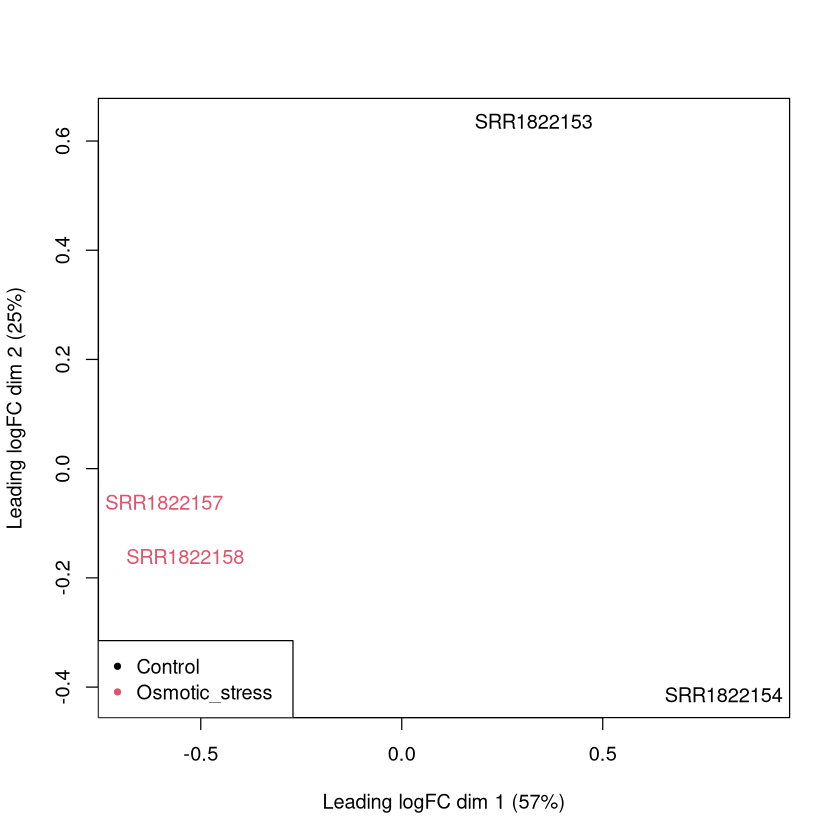

In [13]:
plotMDS(y, col=as.numeric(y$samples$group))
legend("bottomleft", as.character(unique(y$samples$group)), col=1:3, pch=20)

## Estimating the Dispersion

In [14]:
y <- estimateCommonDisp(y,verbose=T)

Disp = 0.04285 , BCV = 0.207 


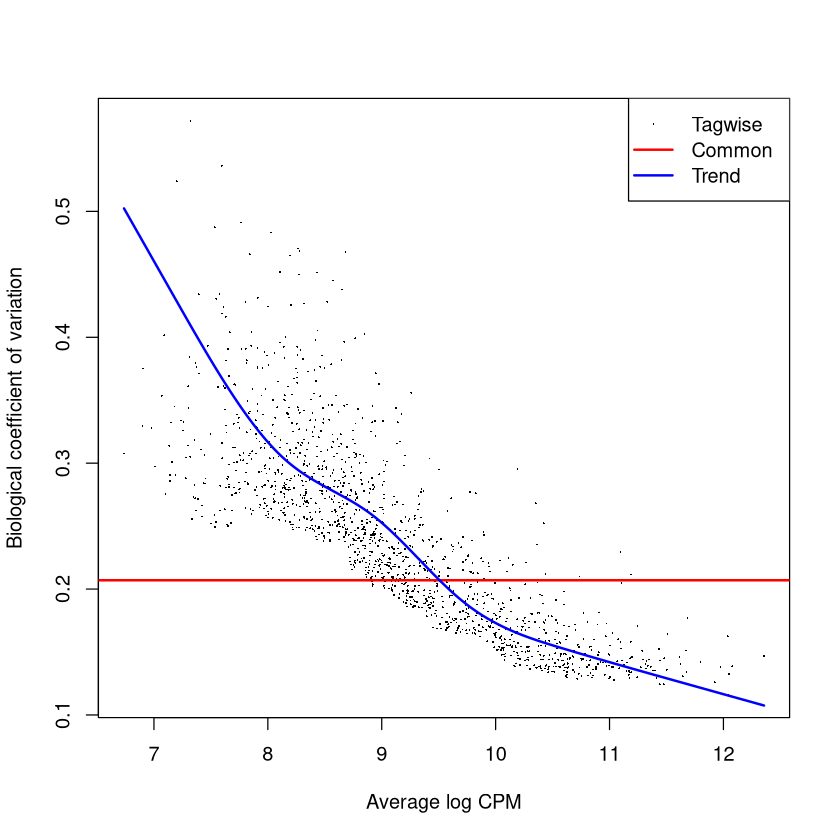

In [15]:
y <- estimateTrendedDisp(y)
y <- estimateTagwiseDisp(y)
plotBCV(y)

# <span style="color:red">TODO, read the doc to check what to do with such dispersion...</span>.

## Differential accessibility
Once the dispersions are estimated, we can proceed with testing procedures for determining differential accessibility. The function exactTest() conducts tagwise tests using the exact negative binomial test. The test results for the n most significant tags are conveniently displayed by the topTags() function. By default, Benjamini and Hochberg's algorithm is used to control the false discovery rate (FDR).

In [16]:
et <- exactTest(y)
topTags(et)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
I_38_709,-1.959148,11.349409,1.268285e-13,1.799697e-10
XI_368984_369722,2.537513,10.074974,3.339098e-12,2.369090e-09
VIII_280214_281434,1.915442,10.814307,5.130197e-12,2.426583e-09
I_229476_230170,-2.165746,10.806801,2.618735e-11,9.289964e-09
IV_593320_593723,2.721805,9.807827,3.658572e-11,1.038303e-08
XIII_923374_924306,-1.684087,11.336036,4.603262e-11,1.088671e-08
IV_62083_62727,2.407922,10.255807,7.871516e-11,1.595669e-08
IV_1524846_1525490,-1.803993,11.000377,1.082304e-10,1.919737e-08
XII_35_286,-1.865972,10.339071,5.061966e-10,7.617224e-08


The number of differentially accessible regions at FDR< 0:05 is:

In [17]:
Z=summary(de <- decideTestsDGE(et, p.value=0.05, adjust="BH"))
Z

       Osmotic_stress-Control
Down                       67
NotSig                   1297
Up                         55

The function plotSmear generates a plot of the tagwise log-fold-changes against log-cpm. Differential tags are highlighted on the plot. 

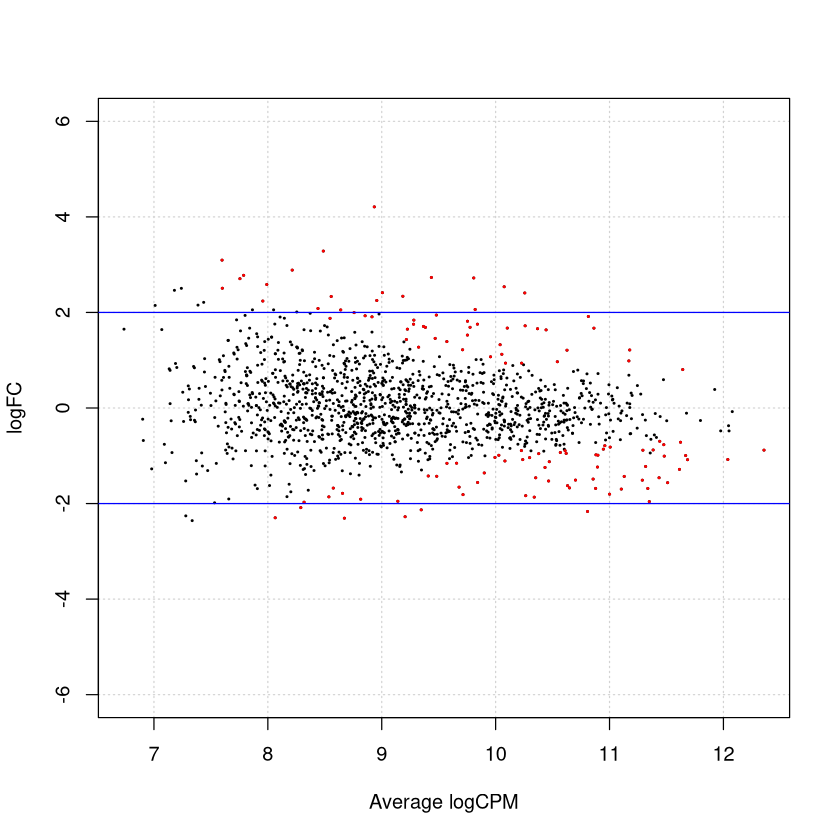

In [18]:
detags <- rownames(y)[as.logical(de)]
plotSmear(et, ylim=c(-6,6), de.tags=detags)
abline(h = c(-2, 2), col = "blue")

## Export the differential analysis results

In [19]:
et.df = as.data.frame(do.call(rbind, et))
write.table(et.df,"differential_accessibility.tsv",quote=FALSE,row.names=TRUE,sep="\t",col.names=NA)

# <span style="color:red">TODO, read the doc to check if GLM would be more appropriate </span>.